---
title: "[Launch the UI](https://colab.research.google.com/drive/1bDlIFzHvnlR-U3lWVGLJAGq3KwcpvlxG?usp=sharing)"
---



🚀 Launch the server locally and explore the interactive UI to query legal provisions and get evidence-backed results instantly!

## Repository Clone and Setup

First, pull the project source code, initialize the execution environment, and run the data preprocessing.

In [ ]:
#| output: false
#| code-fold: false

!git clone https://github.com/Fan-Luo/Legal-RAG.git
%cd Legal-RAG
!python -m scripts.setup

Cloning into 'Legal-RAG'...
remote: Enumerating objects: 751, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 751 (delta 186), reused 234 (delta 168), pack-reused 454 (from 1)
Receiving objects: 100% (751/751), 963.08 KiB | 3.46 MiB/s, done.
Resolving deltas: 100% (378/378), done.
/content/Legal-RAG


## Start the local LegalRAG API server

In [ ]:
#| code-summary: "To launch the interactive UI, the LegalRAG backend is started as a local service using Uvicorn."
#| code-fold: false
#| output: false

import os, time, subprocess, requests
from legalrag.config import AppConfig
cfg = AppConfig.load(None)
PORT = 7900

env = {
    **os.environ,
    "PORT": str(PORT),
    cfg.llm.qwen_model_env: "Qwen/Qwen2.5-3B-Instruct",  
}

uv = subprocess.Popen(
    ["python", "-m", "uvicorn", "legalrag.api.server:app",
     "--host", "0.0.0.0", "--port", str(PORT), "--log-level", "info"],
    env=env,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1
)

[uvicorn] The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
[uvicorn] 
[uvicorn] 0it [00:00, ?it/s]
[uvicorn] 0it [00:00, ?it/s]
[uvicorn] /usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
[uvicorn]   re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
[uvicorn] /usr/local/lib/python3.12/dist-packages/jieba/__init__.py:46: SyntaxWarning: invalid escape sequence '\s'
[uvicorn]   re_skip_default = re.compile("(\r\n|\s)", re.U)
[uvicorn] /usr/local/lib/python3.12/dist-packages/jieba/finalseg/__init__.py:78: SyntaxWarning: invalid escape sequence '\.'
[uvicorn]   re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")
[uvicorn] 2026-01-30 05:10:18.858867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuF

In [ ]:
#| include: false

logf = open("/tmp/uvicorn.log", "w")

def stream_uvicorn(proc):
    for line in proc.stdout:
        logf.write(line); logf.flush()
        print("[uvicorn]", line, end="")

import threading
threading.Thread(target=stream_uvicorn, args=(uv,), daemon=True).start()


# wait local health
for _ in range(60):
    try:
        r = requests.get(f"http://127.0.0.1:{PORT}/health", timeout=2)
        if r.status_code == 200:
            print("Local health OK:", r.text)
            break
    except Exception:
        time.sleep(0.5)
else:
    raise RuntimeError("Local server did not start")

The server listens on a local port and handles incoming requests for retrieval and answer legal generation.



## Expose the Service via a Public Tunnel

With a Cloudflare Tunnel, the locally running LegalRAG service can be accessible via a public endpoint. The process involves launching the cloudflared subprocess to create a secure tunnel, capturing the temporary public URL generated by the tunnel, and ensuring the local service is fully initialized before it becomes publicly reachable.

In [ ]:
#| include: false

!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O cloudflared
!chmod +x cloudflared
!./cloudflared --version

cloudflared version 2026.1.2 (built 2026-01-27-11:31 UTC)


In [ ]:
#| include: false

import logging
import re

public_url = None
url_ready = threading.Event()

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
)
logger = logging.getLogger("cloudflared")


def stream_logs(proc, logger):
    global public_url
    for line in iter(proc.stdout.readline, ''):
        if not line:
            break

        logger.info(f"[cloudflared] {line.rstrip()}")

        m = re.search(r"https://[a-zA-Z0-9.-]+\.trycloudflare\.com", line)
        if m and not url_ready.is_set():
            public_url = m.group(0)
            url_ready.set()

In [ ]:
#| code-summary: "1. Starts a Cloudflare Tunnel for the local service"
#| output: false

proc = subprocess.Popen(
    ["./cloudflared", "tunnel", "--url", f"http://127.0.0.1:{PORT}", "--no-autoupdate"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
)

threading.Thread(
    target=stream_logs,
    args=(proc, logger),
    daemon=True,
).start()

if not url_ready.wait(timeout=60):
    raise RuntimeError("Failed to obtain Cloudflare Tunnel URL")

[uvicorn] INFO:     127.0.0.1:36630 - "GET / HTTP/1.1" 200 OK
[uvicorn] INFO:     127.0.0.1:36632 - "GET /health HTTP/1.1" 200 OK
[uvicorn] INFO:     127.0.0.1:36636 - "GET /ui/ HTTP/1.1" 200 OK
[uvicorn] INFO:     127.0.0.1:36642 - "GET /ui/index.html HTTP/1.1" 200 OK


In [ ]:
#| code-summary: "2. Waits for server warm-up before exposing the endpoint"
#| output: false

ready = False
for _ in range(1000):
    try:
        r = requests.get(f"http://127.0.0.1:{PORT}/ready").json()
        if r.get("warmup_done"):
            ready = True
            break
    except Exception:
        pass
    time.sleep(3)

if not ready:
    raise RuntimeError("Server not ready after warmup")

print("Public URL:", public_url)

## Interactive UI Overview
Through this UI, users can submit queries, visualize retrieved legal provisions, obtain evidence-grounded results, and upload additional reliable legal corpora.

(np.float64(-0.5), np.float64(3193.5), np.float64(1703.5), np.float64(-0.5))

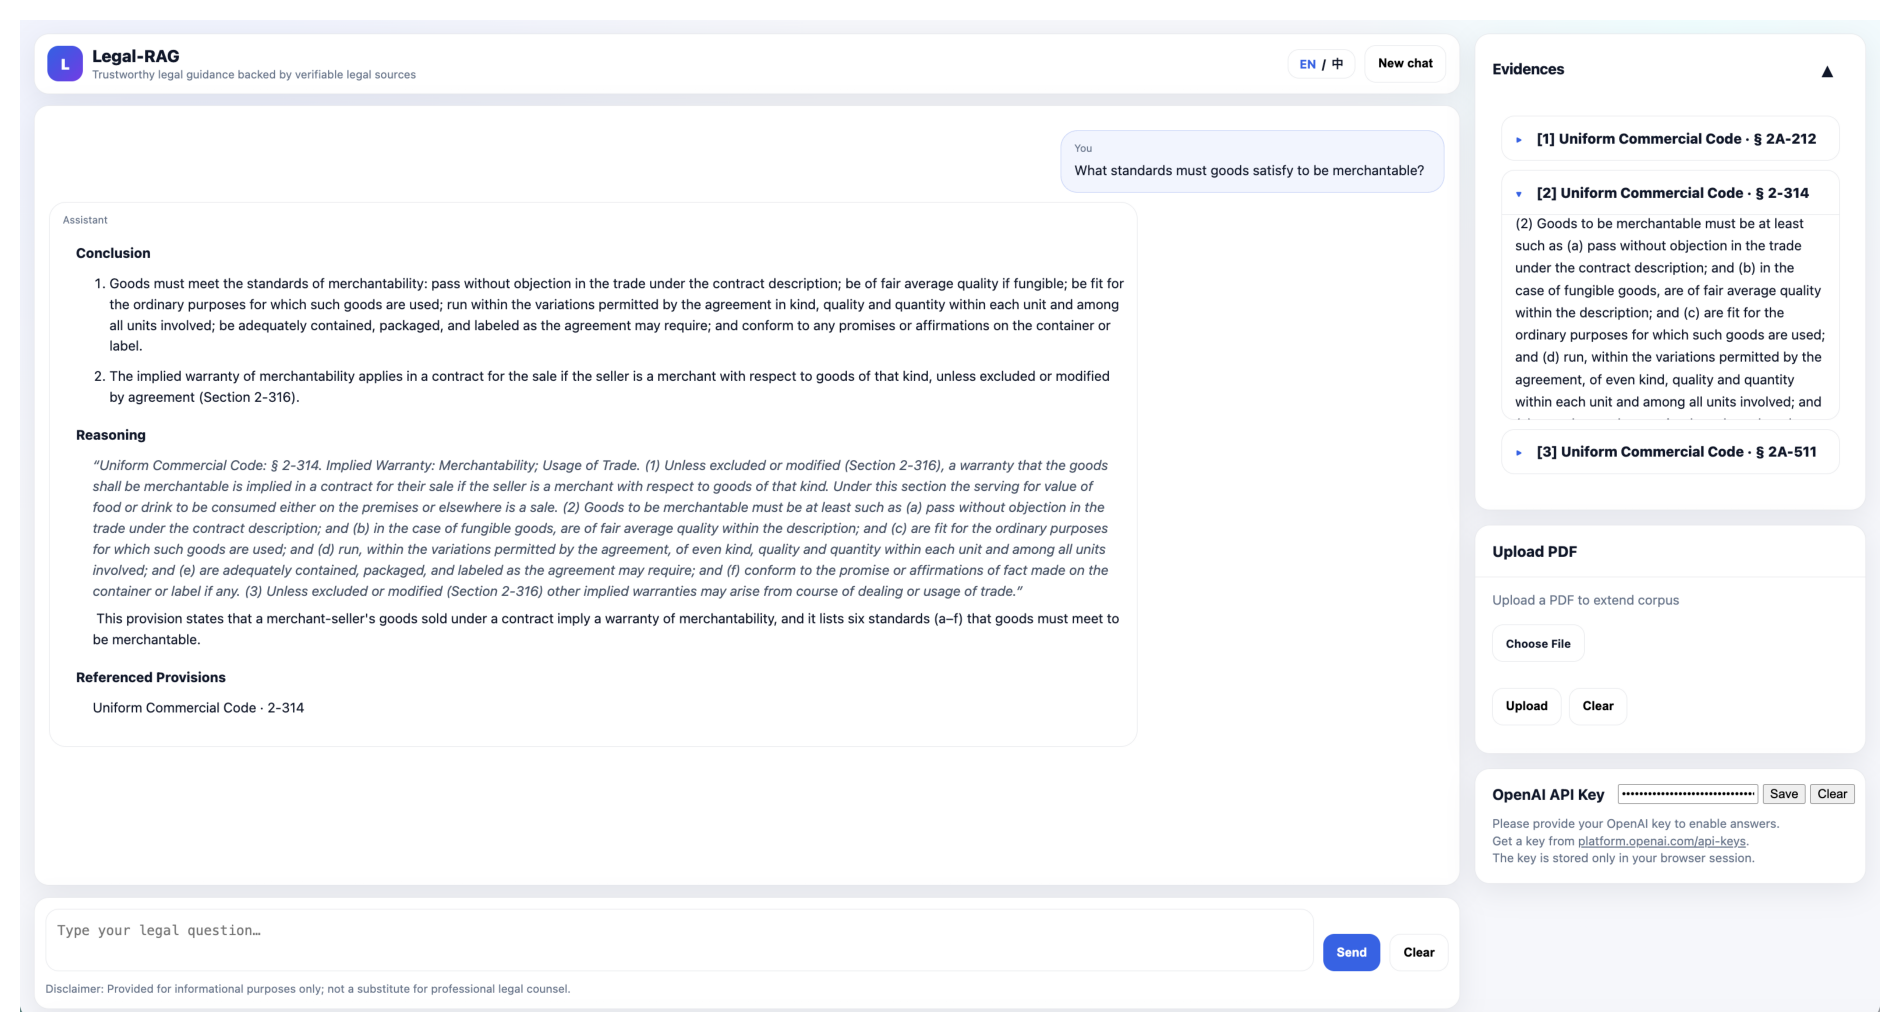

In [3]:
#| echo: false

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(12, 10), dpi=200)
img = mpimg.imread('docs/example-en.png')
plt.imshow(img)
plt.axis('off')
